## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Reading train, test and store datasets:

In [3]:
train = pd.read_csv('train.csv',dtype={'StateHoliday':object},parse_dates=[2])
test = pd.read_csv('test.csv',dtype={'StateHoliday':object},parse_dates=[3])
stores = pd.read_csv('store.csv')

## Exploring datasets:

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
#Finding the number of NAs in each column of train data:
train.apply(lambda x: sum(x.isnull()))

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
#Finding the number of NAs in each column of test data:
test.apply(lambda x: sum(x.isnull()))

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

So there are no null values in train data, whereas in test data 'Open' attribute has 11 NA values. 

In [8]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


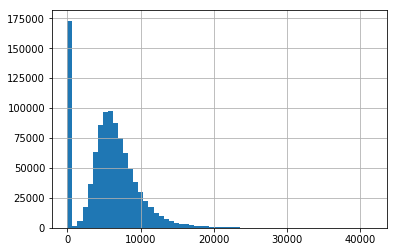

In [9]:
train['Sales'].hist(bins=60)

In [13]:
train[train['Sales']==0].shape[0]

172871

In [15]:
train[train['Open']==0].shape[0]

172817

There are 172,871 rows with sales value as zero. This is becuase those stores are not open on that day. So let us ignore those rows for now.

## Preprocessing datasets:

In [16]:
#Assume store is open if it is null in TEST
test.fillna(1, inplace=True)

In [17]:
#Consider only stores that are open
train = train[train["Open"] != 0]

In [19]:
#Consider only rows that have sales greater than zero.
train = train[train["Sales"] > 0]

In [21]:
#Applying log transformation on the Sales attribute
train['log_sales'] = np.log(train['Sales'])

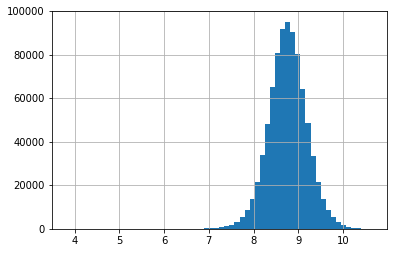

In [22]:
#Plotting the histogram of Log Sales
train['log_sales'].hist(bins=60)

In [23]:
#Merging the train and test datasets with 'Store' dataset
train = pd.merge(train, stores, on='Store')
test = pd.merge(test, stores, on='Store')

In [24]:
#Replacing NA values from Store dataset with 0 (if any)
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [25]:
#Let us define a function 'Coding' which encodes a column by taking a column & encoding rules as parameter
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [26]:
#Encoding StateHoliday as 1 or 0
train["StateHoliday"] = coding(train["StateHoliday"], {'a':1, 'b':1, 'c':1})
test["StateHoliday"] = coding(test["StateHoliday"], {'a':1, 'b':1, 'c':1})

In [27]:
#Converting the StateHoliday values into Float
train['StateHoliday'] = train['StateHoliday'].astype(float)
test['StateHoliday'] = test['StateHoliday'].astype(float)

In [28]:
#Converting the SchoolHoliday values into Float
train['SchoolHoliday'] = train['SchoolHoliday'].astype(float)
test['SchoolHoliday'] = test['SchoolHoliday'].astype(float)

Let us get Year, Month and Day as separate attributes from the given 'Date' attribute:

In [29]:
train['Year'] = train.Date.dt.year
test['Year'] = test.Date.dt.year

In [30]:
train['Month'] = train.Date.dt.month
test['Month'] = test.Date.dt.month

In [31]:
train['Day'] = train.Date.dt.day
test['Day'] = test.Date.dt.day

Let us see the effect of Day, Month and Year on the Sales:

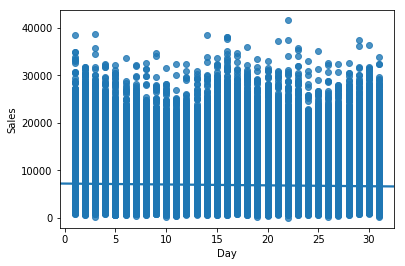

In [32]:
sns.regplot(x='Day',y='Sales',data=train)

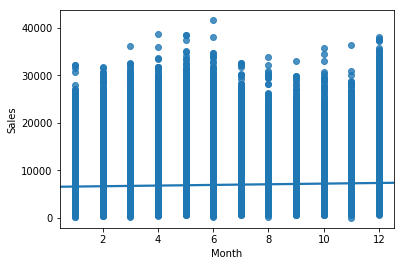

In [33]:
sns.regplot(x='Month',y='Sales',data=train)

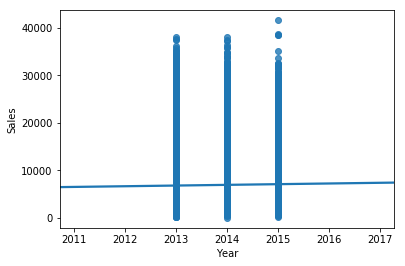

In [34]:
sns.regplot(x='Year',y='Sales',data=train)

In [35]:
train = pd.get_dummies(train,columns=['StoreType','Assortment','Year'])
test = pd.get_dummies(test,columns=['StoreType','Assortment','Year'])
test['Year_2013']=0
test['Year_2014']=0

## Building models:

Removing the unwanted columns like Store, Date, Customers, CompetitionOpenSinceYear, Promo2SinceYear and PromoInterval

In [36]:
X = train[train.columns.difference(['Sales','log_sales','Store','Date','Customers','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'])]
y = train['log_sales']

#Splitting the train data for training and validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

#Removing unwanted columns in Test data
X_test = test[test.columns.difference(['Id','Store','Date','Customers','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'])]

In [37]:
lm = LinearRegression()

lm.fit(X_train,y_train)

lm_pred = lm.predict(X_val)

In [38]:
rmse_lm = np.sqrt(mean_squared_error(y_val,lm_pred))
rmse_lm

0.37233118640547147

In [39]:
rf = RandomForestRegressor(n_estimators=100,max_depth=15)

rf.fit(X_train,y_train)

rf_pred = rf.predict(X_val)

In [40]:
rmse_rf = np.sqrt(mean_squared_error(y_val,rf_pred))
rmse_rf

0.23412686009173148

In [41]:
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)

xgb.fit(X_train,y_train)

xg_pred = xgb.predict(X_val)

In [42]:
rmse_xgb = np.sqrt(mean_squared_error(y_val,xg_pred))
rmse_xgb

0.1095157506898454

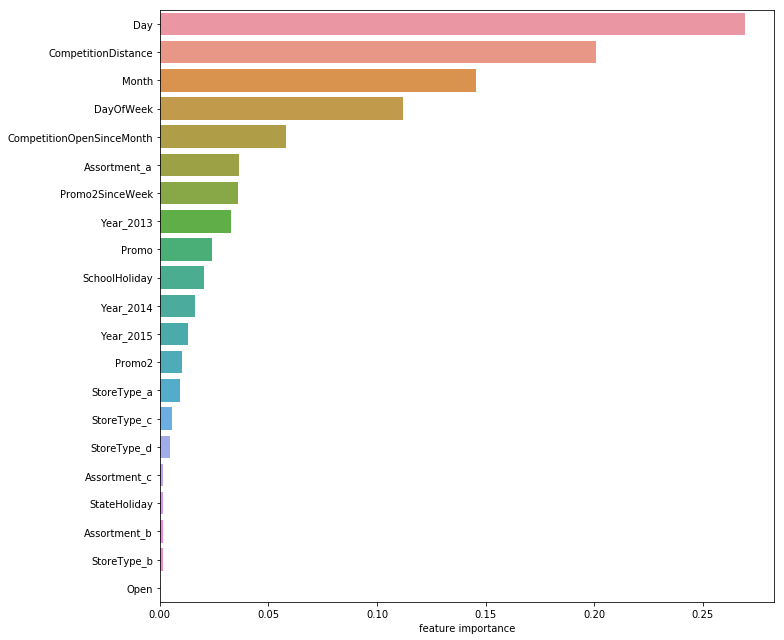

In [43]:
ranking = np.argsort(-xgb.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=xgb.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

### Now let us use Test data on the XGBoost model :

In [44]:
xgb_final = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)

xgb_final.fit(X,y)

xgb_pred_final = xgb.predict(X_test)

In [51]:
xgb_sub = pd.DataFrame({
    'Id':test['Id'].astype(int),
    'Sales': np.exp(xgb_pred_final)
},columns=['Id','Sales'])

xgb_sub_final = xgb_sub.sort_values(by='Id',ascending=True)

xgb_sub_final.to_csv('xgb_sub_final.csv',index=False)